In [1]:
"""
XGBoost multiclassifier for roof materials in D.C.
"""

import os, sys, glob, time
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import rasterio as rio
import xgboost as xgb
import gc

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score

# Functions!
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

print(os.getcwd())

# maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
homedir = '/home/jovyan/data-store/data/iplant/home/maco4303/data/' # cyverse

print("Imports successful!")

/home/jovyan/data-store/opp-rooftop-mapping/code
Imports successful!


In [ ]:
# Load the image data

In [2]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
stack_da_fp = os.path.join(homedir,'OPP/planet/denver/denver_0815_psscene8b_final_norm.tif') # cyverse
stack_da = rxr.open_rasterio(stack_da_fp, masked=True, cache=False).squeeze()
print_raster(stack_da, open_file=False)
band_names = list(stack_da.long_name)
print(f"Band names: {band_names}")
del stack_da

shape: (14939, 6330)
resolution: (3.0, -3.0)
bounds: (489558.0, 4383960.0, 508548.0, 4428777.0)
sum: 15.8248291015625
CRS: EPSG:32613
NoData: None
Band names: ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5']


In [ ]:
# # Prep the data columns
# band_names_plus = band_names
# band_names_plus.append('class_code')
# band_names_plus.append('uid')
# band_names_plus

In [3]:
# Load the training data (footprints)
# gdf_path = os.path.join(maindir,'data/tabular/mod/dc_data/training/dc_data_reference_footprint_sampled.csv')
ref_fp = os.path.join(homedir,'OPP/training/denver/denver_data_reference_footprints_sampled.gpkg')
ref = gpd.read_file(ref_fp)
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,nir,NDBIbg,NDBIrg,NISI,MNF1,NISI5x5,geometry
0,78TL,TL,Tile,271.028875,4710.0,-0.269367,0.761426,-0.261942,0.142143,-0.075536,1.295256,"MULTIPOLYGON (((502162.154 4397355.647, 502162..."
1,269TL,TL,Tile,3885.053236,22307.0,-0.491559,-0.228959,0.145086,-0.381386,-0.528288,1.630611,"MULTIPOLYGON (((503091.622 4397021.987, 503101..."
2,490TL,TL,Tile,2018.268605,6250.0,0.165630,0.121267,1.540670,-0.037652,-0.156279,0.792929,"MULTIPOLYGON (((501990.912 4396754.280, 502007..."
3,497TL,TL,Tile,273.843801,6370.0,-0.163570,-0.456508,-1.066501,-1.018041,-0.692620,0.178836,"MULTIPOLYGON (((502773.275 4396965.742, 502773..."
4,537TL,TL,Tile,281.649002,6000.0,0.124112,0.416955,0.378783,0.538502,0.390621,0.340135,"MULTIPOLYGON (((502162.107 4396885.437, 502168..."


In [4]:
print(ref['class_code'].value_counts())

class_code
CS    86561
WS    10642
AP     8117
TL     2843
CN     2757
SL      230
TG      228
Name: count, dtype: int64


In [ ]:
# Create a balanced sample

In [5]:
ref.columns

Index(['uid', 'class_code', 'description', 'areaUTMsqft', 'lotSizeSqft', 'nir',
       'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5', 'geometry'],
      dtype='object')

In [6]:
# Create a numeric code column
ref['code'], _ = pd.factorize(ref['class_code'])
# Create a dictionary mapping class_code to code
class_mapping = dict(zip(ref['class_code'], ref['code']))
desc_mapping = dict(zip(ref['class_code'], ref['description']))
print(f"Class mapping: {class_mapping}\nDescription mapping: {desc_mapping}")

Class mapping: {'TL': 0, 'WS': 1, 'CN': 2, 'AP': 3, 'SL': 4, 'TG': 5, 'CS': 6}
Description mapping: {'TL': 'Tile', 'WS': 'Wood shake/shingle', 'CN': 'Concrete', 'AP': 'Asphalt', 'SL': 'Slate', 'TG': 'Tar and gravel', 'CS': 'Composition Shingle'}


In [7]:
# Perform balanced sampling (random undersampling)
ref_bal = balance_sampling(ref, ratio=20, strategy='undersample')
ref_bal.class_code.value_counts()

class_code
CS    4560
WS    4560
AP    4560
TL    2843
CN    2757
SL     230
TG     228
Name: count, dtype: int64

In [8]:
band_names

['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5']

In [10]:
t0 = time.time()

y = ref_bal['code'] # class code
X = ref_bal[band_names].astype(float) # the image data

# Define dataframes to store results for this feature set
results = pd.DataFrame()  # to store the model performance metrics
feat_imps = pd.DataFrame()  # to store the feature importances
prob_preds = pd.DataFrame()  # for testing optimum cutoff

# Set up the stratified K-fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Loop the folds
fold_idx = 1
for train_index, test_index in skf.split(X, y):
    t00 = time.time()
    print(f'Fold: {fold_idx}')

    # Split into train/test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Calculate class weights
    val_counts = list(y_train.value_counts())
    class_weights = [sum(val_counts) / count for count in val_counts]
    class_weights = class_weights / np.array(class_weights).sum()     # Normalize the weights
    class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
    print(f"Normalized class weights: {class_weights_dict}")
    
    # Map class weights to each sample in the training set
    sample_weights = y_train.map(class_weights_dict).values

    # Initialize the XGBoost classifier for multi-class classification
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y)),
        n_estimators=1001,
        learning_rate=0.01,
        max_depth=8,
        random_state=42
    )

    # Fit the model
    xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

    # Store feature importance
    fold_imps = pd.DataFrame({
        'Fold': fold_idx,
        'Feature': X.columns,
        'Importance': xgb_model.feature_importances_
    })

    feat_imps = pd.concat([feat_imps, fold_imps], axis=0)

    # Predict on the test set
    y_pred = xgb_model.predict(X_test)

    # Retrieve the accuracy/performance metrics
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Store the metrics into the results data frame
    fold_results = pd.DataFrame({
        'Fold': [fold_idx],
        'Precision': [precision],
        'Recall': [recall],
        'F1': [f1],
        'MCC': [mcc],
        'Accuracy': [accuracy]
    })
    results = pd.concat([results, fold_results], ignore_index=True)

    # Store the probability values for cutoff testing
    y_pred_proba = xgb_model.predict_proba(X_test)

    # Store probabilities and true labels
    fold_probs = pd.DataFrame({
        'TrueLabel': y_test,
        'PredictedProb': list(y_pred_proba),
        'Fold': fold_idx
    })

    # Concatenate the feature importances and probabilities
    prob_preds = pd.concat([prob_preds, fold_probs], ignore_index=True)

    fold_idx += 1 # fold counter

    del fold_probs, fold_results, fold_imps
    gc.collect()

    t1 = (time.time() - t00) / 60
    print(f"Total elapsed time for fold {fold_idx}: {t1:.2f} minutes.")
    print("\n~~~~~~~~~~\n")

t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

# # Append the feature set-specific results to the overall results dataframes
# all_results = pd.concat([all_results, results], ignore_index=True)
# all_feat_imps = pd.concat([all_feat_imps, feat_imps], ignore_index=True)
# all_prob_preds = pd.concat([all_prob_preds, prob_preds], ignore_index=True)

# del results, feat_imps, prob_preds

Fold: 1
Normalized class weights: {0: 0.021690335285974877, 1: 0.021690335285974877, 2: 0.021690335285974877, 3: 0.034799505869288865, 4: 0.03586508300307853, 5: 0.43003447349584983, 6: 0.4342299317738581}
Total elapsed time for fold 2: 0.20 minutes.

~~~~~~~~~~

Fold: 2
Normalized class weights: {0: 0.021690335285974877, 1: 0.021690335285974877, 2: 0.021690335285974877, 3: 0.034799505869288865, 4: 0.03586508300307853, 5: 0.43003447349584983, 6: 0.4342299317738581}
Total elapsed time for fold 3: 0.19 minutes.

~~~~~~~~~~

Fold: 3
Normalized class weights: {0: 0.021690335285974877, 1: 0.021690335285974877, 2: 0.021690335285974877, 3: 0.034799505869288865, 4: 0.03586508300307853, 5: 0.43003447349584983, 6: 0.4342299317738581}
Total elapsed time for fold 4: 0.20 minutes.

~~~~~~~~~~

Fold: 4
Normalized class weights: {0: 0.021690316696744715, 1: 0.021690316696744715, 2: 0.021690316696744715, 3: 0.03478587718774534, 4: 0.035879508151326206, 5: 0.43003410494415617, 6: 0.4342295596265382}
To

In [11]:
results.head()

,Fold,Precision,Recall,F1,MCC,Accuracy
0,1,0.632408,0.414894,0.366265,0.330932,0.414894
1,2,0.579563,0.380952,0.314771,0.285215,0.380952
2,3,0.592164,0.392604,0.337369,0.304878,0.392604
3,4,0.590108,0.388045,0.327485,0.296636,0.388045
4,5,0.593423,0.396150,0.335277,0.306430,0.396150


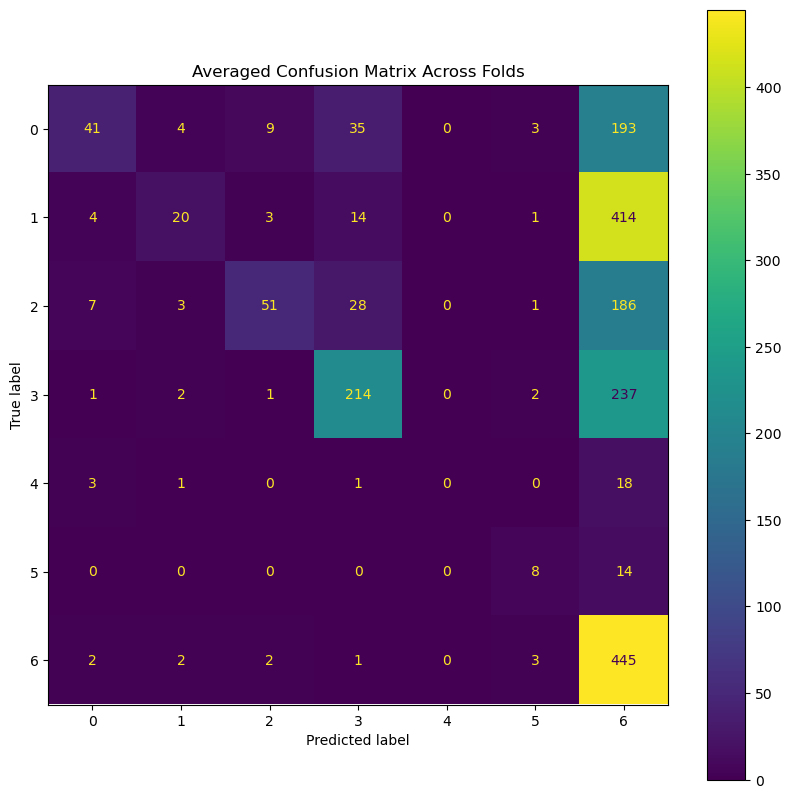

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Initialize the confusion matrix accumulator
n_classes = len(np.unique(y))  # Number of classes
cm_accumulator = np.zeros((n_classes, n_classes))

all_true_labels = []
all_pred_labels = []

# Loop over the folds and compute confusion matrices
for fold in range(1, fold_idx):
    fold_data = prob_preds[prob_preds['Fold'] == fold]
    true_labels = fold_data['TrueLabel']
    pred_labels = np.argmax(np.vstack(fold_data['PredictedProb']), axis=1)

    all_true_labels.extend(true_labels)
    all_pred_labels.extend(pred_labels)

    # Compute the confusion matrix for this fold
    cm_fold = confusion_matrix(true_labels, pred_labels, labels=np.unique(y))

    # Accumulate the confusion matrix
    cm_accumulator += cm_fold

# Average the confusion matrix by the number of folds
cm_avg = cm_accumulator / (fold_idx - 1)

# Round to the nearest integer (optional, as you mentioned it's fine)
cm_avg = np.rint(cm_avg).astype(int)

# Display the averaged confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_avg, display_labels=np.unique(y))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.title('Averaged Confusion Matrix Across Folds')

# Save the figure
plt.savefig(os.path.join('/home/jovyan/data-store/results/FigX_denver_xgboost_confusion_matrix_avg.png'), dpi=300, bbox_inches='tight')

plt.show()

In [13]:
from sklearn.metrics import classification_report

# Create a classification report and convert it to a DataFrame
cor_labels = [label for label, idx in sorted(class_mapping.items(), key=lambda item: item[1])]
cr_df = pd.DataFrame(classification_report(all_true_labels, all_pred_labels, target_names=cor_labels, output_dict=True)).transpose()

# Compute the average accuracy metrics across the 10 folds
average_metrics = cr_df.loc[cor_labels].mean()

# Display the DataFrame
cr_df

/opt/conda/envs/macrosystems/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/macrosystems/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/macrosystems/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
TL,0.707612,0.143862,0.239111,2843.00000
WS,0.648562,0.044518,0.083316,4560.00000
CN,0.756637,0.186072,0.298690,2757.00000
AP,0.730099,0.468640,0.570856,4560.00000
SL,0.000000,0.000000,0.000000,230.00000
TG,0.436464,0.346491,0.386308,228.00000
CS,0.295399,0.975658,0.453494,4560.00000
accuracy,0.394670,0.394670,0.394670,0.39467
macro avg,0.510682,0.309320,0.290254,19738.00000
weighted avg,0.599403,0.394670,0.336524,19738.00000


In [14]:
# Save out the results
results_dir = '/home/jovyan/data-store/results/'
results.to_csv(os.path.join(results_dir,'denver_xgboost_folds_results.csv'))
feat_imps.to_csv(os.path.join(results_dir,'denver_xgboost_folds_feat_imps.csv'))
prob_preds.to_csv(os.path.join(results_dir,'denver_xgboost_folds_prob_peds.csv'))
cr_df.to_csv(os.path.join(results_dir,'denver_xgboost_classification_report_avg.csv'))